# Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
import datetime as dt
import tkinter.messagebox as mbox


from urllib.parse import urljoin

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'



import sys
sys.path.insert(1, 'C:/Users/Woon/Desktop/Columbia/Applied Analytics/Term3/Sentiment_SNP')
import helper_functions
from helper_functions import *



# Environment settings: 
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Collection

# Import Libraries for NLP

In [49]:
from collections import defaultdict
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)

import nltk
from nltk import word_tokenize

from transformers import pipeline

In [8]:
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Ticker

In [9]:
from urllib.request import Request, urlopen
from urllib.error import HTTPError
import socket
import urllib

In [10]:
text_input = input("Type in the Ticker: ")
print("You entered:", text_input)

#text_input = 'xom'

You entered: xom


# Yahoo Finance News

In [11]:
now = dt.datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Report Date = ", dt.datetime.today())
print("Report Time =", current_time)
YAHOO_NEWS_URL = f'https://finance.yahoo.com/quote/{text_input}?p={text_input}&.tsrc=fin-srch'
news_df = scrape_yahoo_news(YAHOO_NEWS_URL)

Report Date =  2023-04-26 16:01:51.106193
Report Time = 16:01:51


In [12]:
sentiment = [None] * len(news_df)
sentiment_score = [None] * len(news_df)
index = -1
for sentence in news_df['headline']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
news_df['Sentiment'] = sentiment
news_df['Score'] = sentiment_score


sentiment = [None] * len(news_df)
sentiment_score = [None] * len(news_df)
index = -1
for sentence in news_df['content']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
news_df['Sentiment2'] = sentiment
news_df['Score2'] = sentiment_score

In [13]:
#news_df[news_df['Score'] > 0.8] 
news_df2 = news_df[news_df['Score'] > 0.8] [news_df[news_df['Score'] > 0.8] ['Score2'] > 0.8].reset_index()

In [14]:
news_df2.head(20)

,index,source,time,headline,content,Sentiment,Score,Sentiment2,Score2
0,0,Investor's Business Daily,3 hours ago,Chevron Stock A Better Bet Than Exxon Mobil? Wall Street Sees Profit Down 20% For Both In 2023,Chevron stock might outperform its larger rival Exxon Mobil in 2023. Investors will have to wait for Q1 earnings this week to see if its possible.,NEGATIVE,0.998958,NEGATIVE,0.997203
1,1,Zacks,7 hours ago,Why Investors Need to Take Advantage of These 2 Oils-Energy Stocks Now,Why investors should use the Zacks Earnings ESP tool to help find stocks that are poised to top quarterly earnings estimates.,NEGATIVE,0.986834,NEGATIVE,0.994052
2,2,Bloomberg,7 hours ago,Oil Patch Is Poised for Buyout Wave as US Drillers Seek New Land,"(Bloomberg) -- The US energy patch is ripe for a takeover boom, as oil and gas producers flush with cash turn to dealmaking to find new sites to drill. Most Read from BloombergTesla Drops Model Y Starting Price Below the Average US VehicleUK Blocks Microsoft’s $69 Billion Activision Deal Quants Are ‘Out of Ammo’ for Buying Stocks, Goldman WarnsFirst Republic Bank to Weigh Up to $100 Billion in Asset SalesBRICS Draws Membership Bids From 19 Nations Before SummitEnergy producers raked in recor...",NEGATIVE,0.994870,NEGATIVE,0.995394
3,3,Zacks,7 hours ago,Will ExxonMobil's (XOM) Upstream Business Aid Q1 Earnings?,"Since ExxonMobil (XOM) has significant exposure to the upstream business, favorable oil price is likely to have aided Q1 earnings.",NEGATIVE,0.996777,POSITIVE,0.988443
4,4,Investopedia,9 hours ago,Exxon's Profit Likely Rose 20% as Oil Prices Slumped,"Even with lower oil prices versus a year ago, when they surged after Russia's invasion of Ukraine, Exxon Mobil's profit likely gained significantly in the first-quarter of 2023.",NEGATIVE,0.997173,POSITIVE,0.996988
5,5,Zacks,20 hours ago,Should Investors Buy Chevron or Exxon Mobil Stock Ahead of Q1 Earnings?,"With crude oil prices recently edging toward $80 a barrel investors may be wondering if it's time to buy Chevron (CVX) or Exxon Mobil (XOM) stock before their first-quarter earnings reports on Friday, April 28.",NEGATIVE,0.997791,NEGATIVE,0.998967
6,6,Investor's Business Daily,21 hours ago,Is It Time To Buy XOM Stock As Exxon Mobil Flirts With Its All-Time High?,XOM stock is within 3% of its February all-time high. Exxon reports earnings this week. Can it deliver and impress investors?,NEGATIVE,0.998980,POSITIVE,0.977108
7,7,Bloomberg,yesterday,Oil Falls as Cloudy Outlook Heightens Risk-Off Sentiment,"(Bloomberg) -- Oil fell amid widespread losses on Wall Street as lackluster earnings and diminished consumer confidence prompted broad selling. Most Read from BloombergTesla Drops Model Y Starting Price Below the Average US VehicleFox Fired Its Biggest Star Tucker Carlson, Who Badmouthed BossesBRICS Draws Membership Bids From 19 Nations Before SummitAirline Cancels Passengers’ $10,000 Business Class Tickets Sold in Error for $300First Republic Bank to Weigh Up to $100 Billion in Asset SalesWest",NEGATIVE,0.998710,NEGATIVE,0.999694
8,8,Zacks,yesterday,Is a Beat in Store for ExxonMobil (XOM) in Q1 Earnings?,Higher production and favorable price are likely to have boosted ExxonMobil's (XOM) earnings in Q1.,NEGATIVE,0.998200,POSITIVE,0.982614
9,9,Insider Monkey,yesterday,10 Best Fuel Stocks to Buy Now,"In this article, we will discuss the 10 best fuel stocks to buy now. To skip the detailed analysis and recent updates on the energy industry, go directly to the 5 Best Fuel Stocks to Buy Now. Oil Demand Likely to Grow Production cuts announced by major oil producers might cause disruptions in the global […]",POSITIVE,0.999305,NEGATIVE,0.993285


In [15]:
text_input2 = input("How many rows of news?: ")
text_input2 = int(text_input2)

# Sentiment

<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

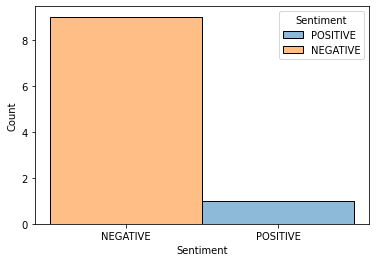

In [16]:
sns.histplot(x = 'Sentiment', data = news_df2[:text_input2], hue = 'Sentiment', hue_order=['POSITIVE', 'NEGATIVE'])

<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

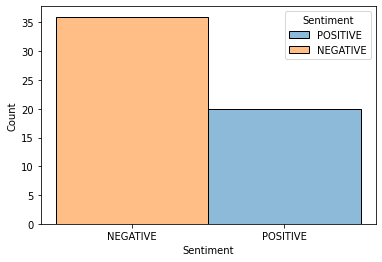

In [17]:
sns.histplot(x = 'Sentiment', data = news_df2, hue = 'Sentiment', hue_order=['POSITIVE', 'NEGATIVE'])

# Headline Trigram

In [18]:
## Get the bar chart from 5 rated reviews ##
freq_dict = defaultdict(int)
for sent in news_df["headline"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(20), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"])
fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots');

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



# Content Trigram

In [19]:
## Get the bar chart from 5 rated reviews ##
freq_dict = defaultdict(int)
for sent in news_df["content"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(20), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"])
fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots');

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



# Finviz

In [20]:
url = f"https://finviz.com/quote.ashx?t={text_input}&ty=c&ta=1&p=d"


headers = {"User-Agent": "Mozilla/5.0"}
cookies = {"CONSENT": "YES+cb.20210720-07-p0.en+FX+410"}

req = Request(url, headers=headers)

try:
    contents = urlopen(req).read() 
    soup = BeautifulSoup(contents, features="html.parser")

    sentence2 = []

    for tag in soup.find_all('a'):

        sentence = tag.text.split(".")
        sentence2.append(sentence)

except urllib.error.HTTPError as err:
    print(err.code)

except socket.timeout as se:
    print("socket timeout")

In [21]:
df = pd.DataFrame(sentence2)

In [22]:
df['Headline'] = df[0]
df['Sentiment'] = -2
df = pd.DataFrame(list(zip(df['Headline'], df['Sentiment'])), columns=['Headline', 'Sentiment'])

In [23]:
i = []

for string in df['Headline']:
    i.append(count_words(string))

df['word_count'] = i

In [24]:
sentiment = [None] * len(df)
sentiment_score = [None] * len(df)
index = -1
for sentence in df['Headline']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
df['Sentiment'] = sentiment
df['Score'] = sentiment_score

In [25]:
df = df[df['word_count'] > 10]
df['Headline_Lower'] = df['Headline'].str.lower()

<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

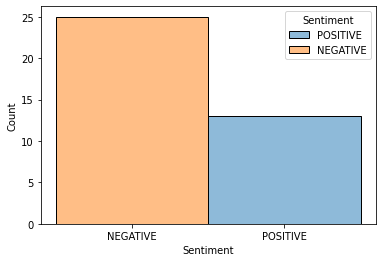

In [26]:
sns.histplot(x = 'Sentiment', data = df[df['Score'] > 0.8], hue = 'Sentiment', hue_order=['POSITIVE', 'NEGATIVE'])

In [27]:
## Get the bar chart from 5 rated reviews ##
freq_dict = defaultdict(int)
for sent in df["Headline_Lower"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(10), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"])
fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots');

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



# Forecast

In [28]:
#Past 3 year data
spy_ohlc_df = yf.download(text_input, start=dt.datetime.today() - dt.timedelta(days=1095), end=dt.datetime.today())
df=spy_ohlc_df.reset_index()

[*********************100%***********************]  1 of 1 completed


In [29]:
start_time = pd.Timestamp(df['Date'][0])
end_time = pd.Timestamp(df['Date'][len(df)-1])
time_range = pd.date_range(start_time, end_time, freq=df['Date'][1] - df['Date'][0] )

time_list = time_range.tolist()


time_list = pd.to_datetime(time_list)
index = range(len(time_list))

df_dates = pd.DataFrame(index, columns = ['Date'])
df_dates['Date'] = time_list

#Ensure all reading time exists, fill with 0 for missing reading times
df = pd.merge(df, df_dates, on='Date', how='right')

df.fillna(method='ffill', inplace=True)

In [30]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15,6)
# sns.lineplot(x = 'Date', y = 'Close', data = df)
# plt.show()

In [31]:
# Load SPY price data
spy_data = df
spy_data = df[['Date', 'Close']]
spy_data.columns = ['ds', 'y']

# Initialize Prophet model
model = Prophet()

# Fit the model on SPY data
model.fit(spy_data)

# Create future dates for forecasting
future_dates = model.make_future_dataframe(periods=365, include_history=False)

# Make predictions for future dates
forecast = model.predict(future_dates)

16:03:21 - cmdstanpy - INFO - Chain [1] start processing
16:03:22 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
# fig = model.plot(forecast, xlabel='Date', ylabel='SPY Price')
# fig.set_size_inches(15,6)
# plt.title('Forecasted Price')
# plt.xlabel('dt')
# plt.ylabel('Price')
# plt.show()

# One Year Outlook

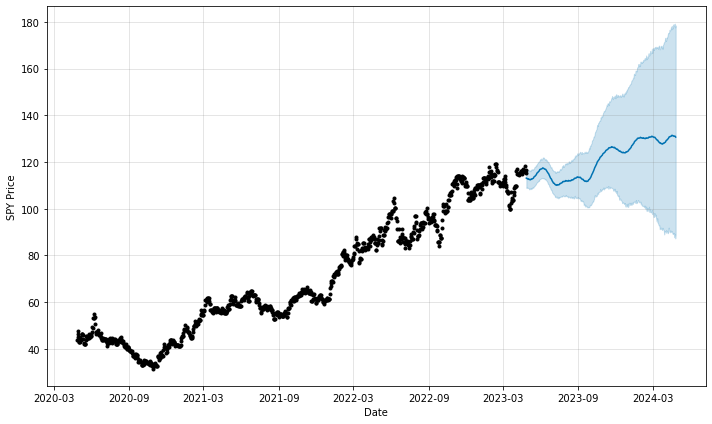

(18743.66901112941, 19838.66901112941)

(90.59991998804605, 150.9998666467434)

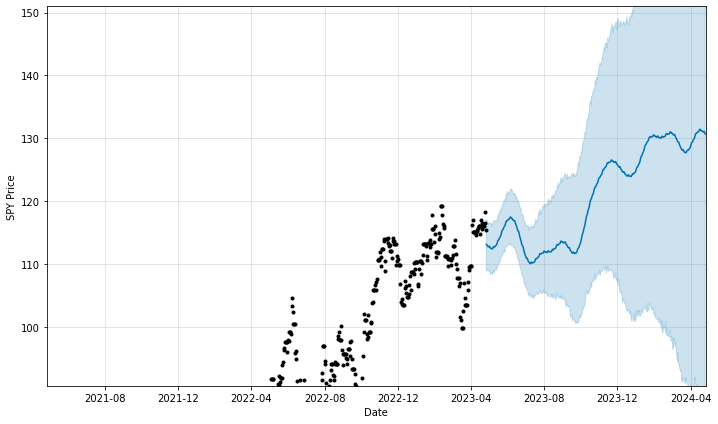

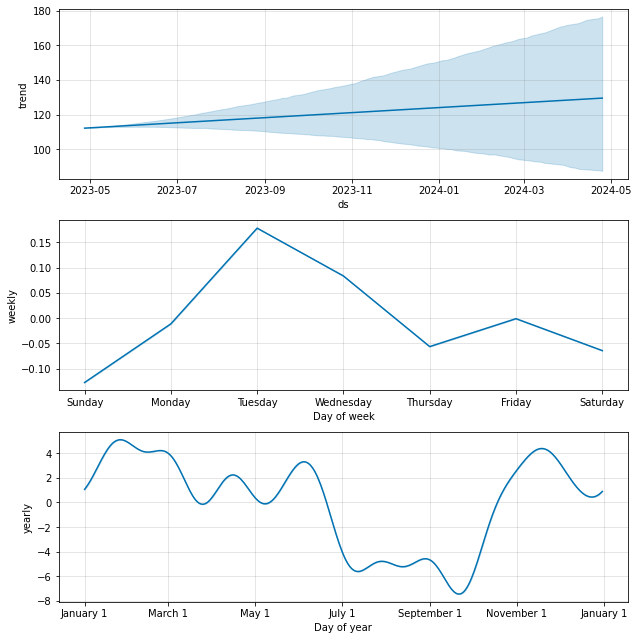

In [33]:
# Plot the forecasted data
model.plot(forecast, xlabel='Date', ylabel='SPY Price')
plt.xlim(dt.datetime.today() - dt.timedelta(days=730), dt.datetime.today() + dt.timedelta(days=365))
plt.ylim(forecast['yhat'].mean()*0.75, forecast['yhat'].mean()*1.25)

# Plot the forecasted trend and seasonality components
fig = model.plot_components(forecast)
plt.show()

In [34]:
#Past 1 year data
spy_ohlc_df = yf.download(text_input, start=dt.date.today() - dt.timedelta(days=365), end=dt.date.today())
df1=spy_ohlc_df.reset_index()

# spy_ohlc_df = yf.download(text_input, start=dt.date.today() - dt.timedelta(days=7), end=dt.date.today())
# df1=spy_ohlc_df.reset_index()

[*********************100%***********************]  1 of 1 completed


In [35]:
start_time = pd.Timestamp(df1['Date'][0])
end_time = pd.Timestamp(df1['Date'][len(df1)-1])
time_range = pd.date_range(start_time, end_time, freq=df1['Date'][1] - df1['Date'][0] )

time_list = time_range.tolist()


time_list = pd.to_datetime(time_list)
index = range(len(time_list))

df_dates = pd.DataFrame(index, columns = ['Date'])
df_dates['Date'] = time_list

#Ensure all reading time exists, fill with 0 for missing reading times
df1 = pd.merge(df1, df_dates, on='Date', how='right')

df1.fillna(method='ffill', inplace=True)

In [36]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15,6)
# sns.lineplot(x = 'Datetime', y = 'Close', data = df1)
# plt.show()

In [37]:
# Load SPY price data
spy_data = df1
spy_data = df1[['Date', 'Close']]
#spy_data = df1[['Date', 'Close']]
spy_data.columns = ['ds', 'y']

# Initialize Prophet model
model = Prophet()

# Fit the model on SPY data
model.fit(spy_data)

# Create future dates for forecasting
future_dates = model.make_future_dataframe(periods=30, include_history=False)

# Make predictions for future dates
forecast = model.predict(future_dates)


16:03:24 - cmdstanpy - INFO - Chain [1] start processing
16:03:24 - cmdstanpy - INFO - Chain [1] done processing


# 30 Days Outlook

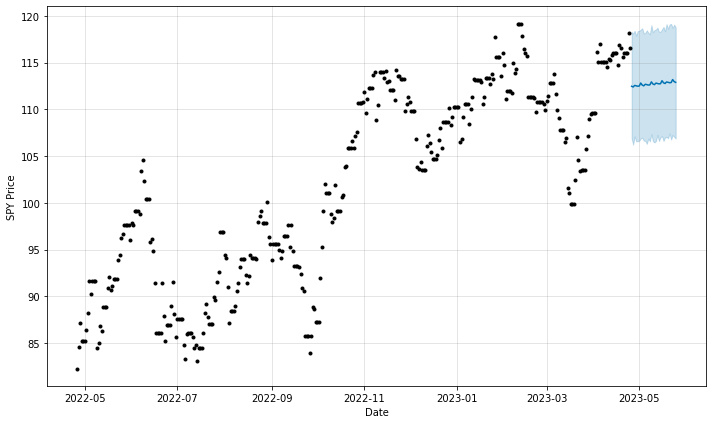

(19413.0, 19503.0)

(101.4627458537558, 124.01002271014599)

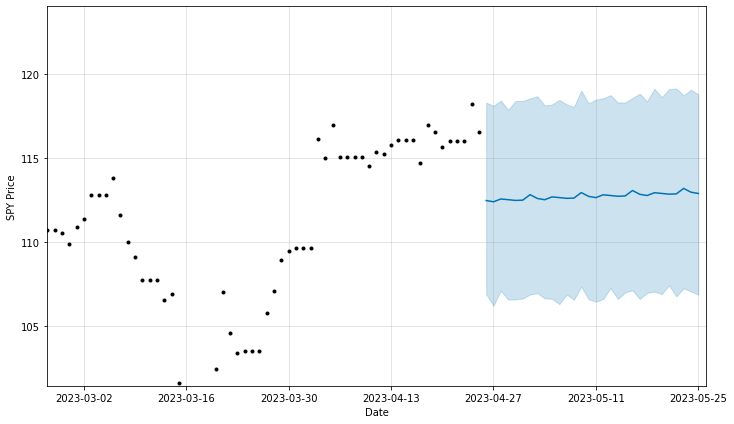

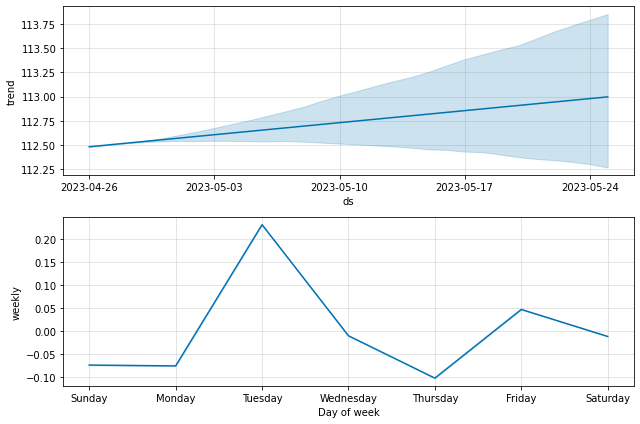

In [38]:
# Plot the forecasted data
model.plot(forecast, xlabel='Date', ylabel='SPY Price')
plt.xlim(dt.date.today() - dt.timedelta(days=60), dt.date.today() + dt.timedelta(days=30))
plt.ylim(forecast['yhat'].mean()*0.9, forecast['yhat'].mean()*1.1)

# Plot the forecasted trend and seasonality components
fig = model.plot_components(forecast)
plt.show()

In [39]:
#Past week data
spy_ohlc_df = yf.download(text_input, start=dt.date.today() - dt.timedelta(days=7), end=dt.date.today(), interval='1m')
df1=spy_ohlc_df.reset_index()

# spy_ohlc_df = yf.download(text_input, start=dt.date.today() - dt.timedelta(days=7), end=dt.date.today())
# df1=spy_ohlc_df.reset_index()

[*********************100%***********************]  1 of 1 completed


In [40]:
start_time = pd.Timestamp(df1['Datetime'][0])
end_time = pd.Timestamp(df1['Datetime'][len(df1)-1])
time_range = pd.date_range(start_time, end_time, freq=df1['Datetime'][1] - df1['Datetime'][0] )

time_list = time_range.tolist()

In [41]:
time_list = pd.to_datetime(time_list)
index = range(len(time_list))

df_dates = pd.DataFrame(index, columns = ['Datetime'])
df_dates['Datetime'] = time_list

In [42]:
#Ensure all reading time exists, fill with 0 for missing reading times
df1 = pd.merge(df1, df_dates, on='Datetime', how='right')

In [43]:
df1.fillna(method='ffill', inplace=True)

In [44]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15,6)
# sns.lineplot(x = 'Datetime', y = 'Close', data = df1)
# plt.show()

In [45]:
# Load SPY price data
spy_data = df1
spy_data = df1[['Datetime', 'Close']]
#spy_data = df1[['Date', 'Close']]
spy_data.columns = ['ds', 'y']

# Initialize Prophet model
model = Prophet()

# Fit the model on SPY data
model.fit(spy_data)

# Create future dates for forecasting
future_dates = model.make_future_dataframe(periods=2880, freq='T', include_history=False)


# Make predictions for future dates
forecast = model.predict(future_dates)


16:03:27 - cmdstanpy - INFO - Chain [1] start processing
16:03:34 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
# fig = model.plot(forecast, xlabel='Date', ylabel='SPY Price')
# fig.set_size_inches(15,6)
# plt.title('Forecasted Price')
# plt.xlabel('dt')
# plt.ylabel('Price')
# plt.show()

# One Day Outlook

In [47]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-04-25 16:00:00,117.071829,116.469529,117.269604,117.071829,117.071829,-0.187027,-0.187027,-0.187027,-0.187027,-0.187027,-0.187027,0.0,0.0,0.0,116.884803
1,2023-04-25 16:01:00,117.070945,116.479914,117.296367,117.070945,117.070945,-0.185810,-0.185810,-0.185810,-0.185810,-0.185810,-0.185810,0.0,0.0,0.0,116.885135
2,2023-04-25 16:02:00,117.070061,116.449588,117.309770,117.070061,117.070061,-0.184593,-0.184593,-0.184593,-0.184593,-0.184593,-0.184593,0.0,0.0,0.0,116.885467
3,2023-04-25 16:03:00,117.069176,116.456116,117.298894,117.069176,117.069176,-0.183378,-0.183378,-0.183378,-0.183378,-0.183378,-0.183378,0.0,0.0,0.0,116.885799
4,2023-04-25 16:04:00,117.068292,116.418953,117.293631,117.068292,117.068292,-0.182162,-0.182162,-0.182162,-0.182162,-0.182162,-0.182162,0.0,0.0,0.0,116.886130


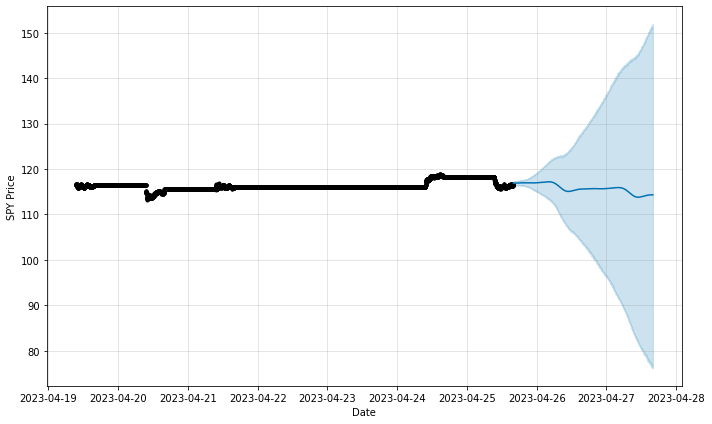

(19471.0, 19474.0)

(113.4828672646637, 118.11482103056835)

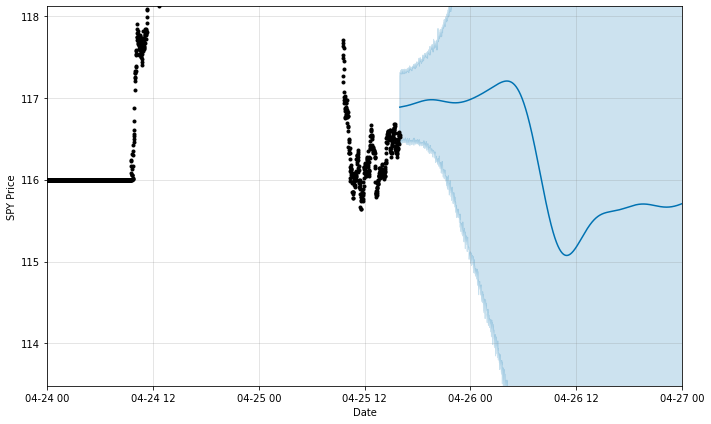

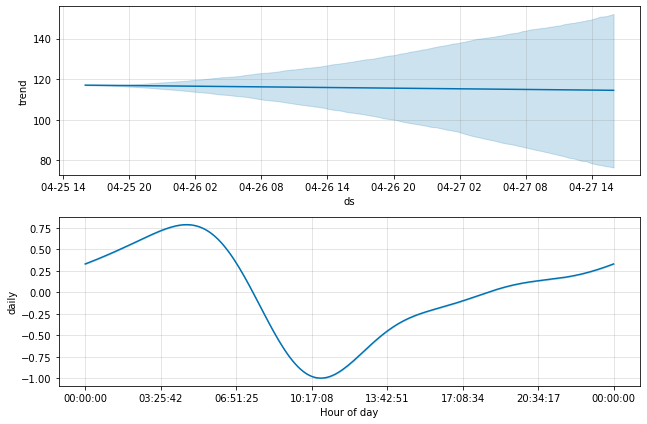

In [48]:
# Plot the forecasted data
model.plot(forecast, xlabel='Date', ylabel='SPY Price')
plt.xlim(dt.date.today() - dt.timedelta(days=2), dt.date.today() + dt.timedelta(days=1))
plt.ylim(forecast['yhat'].mean()*0.98, forecast['yhat'].mean()*1.02)

# Plot the forecasted trend and seasonality components
fig = model.plot_components(forecast)
plt.show()